# Algorithmic Economics - HW 3
#### Kacper Szczepański, Jakub Józefowicz

Let's install the required libraries first

In [1]:
! pip install numpy seaborn pandas


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


We define the player and battlefield representation:

In [3]:
from dataclasses import dataclass
from typing import List
import numpy as np

# battlefield can just be a list of ints

@dataclass
class Player:
    num_resources: int
    strategy: np.ndarray

The best response functions, which although similar are not exactly symmetrical because of how draws are handled.

In [4]:
# this is equivalent to finding k'th (k = num_resources) largest element and then all larger so O(n) instead of O(nlog(n))
def bestPureResponseAtt(att_player, def_player, battlefields):
    num_resources = att_player.num_resources
    def_strat = def_player.strategy
    utils = (1.0-def_strat) * battlefields
    util_idxs = np.argpartition(utils, -num_resources) 
    res = np.zeros_like(def_strat)
    res[util_idxs[-num_resources:]] = 1.0
    return res

# this is equivalent to finding k'th (k = num_resources) largest element and then all larger so O(n) instead of O(nlog(n))
def bestPureResponseDef(att_player, def_player, battlefields):
    num_resources = def_player.num_resources
    att_strat = att_player.strategy
    utils = att_strat * battlefields
    util_idxs = np.argpartition(utils, -num_resources)
    res = np.zeros_like(att_strat)
    res[util_idxs[-num_resources:]] = 1.0
    return res

We also have to implement a calculation of $\epsilon$, this is bounded from the bottom by the difference in paysoff between the players when reacting with any of their best responses against the opponent's mixed strategy.

Let $S$ be the set of pure strategies available to a given player, then:
$$
todo
$$

5 3 4
2 2 2 2 0

In [5]:
def getEpsilon(
    att_player, def_player, battlefields, best_resp_att=None, best_resp_def=None
):
    att_strat = att_player.strategy
    def_strat = def_player.strategy
    if best_resp_att is None:
        best_resp_att = bestPureResponseAtt(att_player, def_player, battlefields)
    if best_resp_def is None:
        best_resp_def = bestPureResponseDef(att_player, def_player, battlefields)
    pay_att = np.sum(best_resp_att * battlefields * (1 - def_strat))
    pay_def = np.sum((1 - best_resp_def) * battlefields * att_strat)

    return abs(pay_att - pay_def)

We are now able to implement ficticious play.

In [6]:
def ficticiousPlay(  # todo intial conditions player
    battlefields, num_res_att, num_res_def, epsilon=0.001, max_iters=1_000_000
):
    assert num_res_att > 0 and num_res_att < len(battlefields)
    assert num_res_def > 0 and num_res_def < len(battlefields)
    assert num_res_att < num_res_def
    #battlefields = np.array(battlefields, dtype=np.double)
    num_battlefields = battlefields.shape[0]
    att_play = Player(num_res_att, np.array([num_res_att/num_battlefields] * num_battlefields, dtype=np.double)) # good default init
    def_play = Player(num_res_def, np.array([num_res_def/num_battlefields] * num_battlefields, dtype=np.double)) # good default init
    epsilons = []
    for t in range(1, max_iters + 1):
        resp_att = bestPureResponseAtt(att_play, def_play, battlefields)
        resp_def = bestPureResponseDef(att_play, def_play, battlefields)
        err = getEpsilon(att_play, def_play, battlefields, resp_att, resp_def)
        epsilons.append(err)
        if err <= epsilon:
            break
        for i, (cur, new) in enumerate(zip(att_play.strategy, resp_att)):
            att_play.strategy[i] = (cur * (t - 1) + new) / t
        for i, (cur, new) in enumerate(zip(def_play.strategy, resp_def)):
            def_play.strategy[i] = (cur * (t - 1) + new) / t

    return att_play.strategy, def_play.strategy, np.array(epsilons) # len(epsilons) gives us the number of iterations the algorithm ran for

Let's generate some nice variety for the input analysis, we will consider games with 10, 20, 30, 40 and 50 battlefields for each we will check situations where the attacker and defender have a low(< ~15%), medium (~40-60%) or high number(>~85%) or resources in comparison to the number of battlefields

In [8]:
import random as r
import pandas as pd
import math

r.seed(42)
input_ranges = ["low", "mid", "high"]
field_sizes = [10 * i for i in range(1, 6)]
range_divisors = [(field_sizes[-1], 1 / 0.15), (1 / 0.4, 1 / 0.6), (1 / 0.85, 1)]
num_samples = 100
input_params = []
column_names = ["field_size", "tokens_att", "tokens_def", "range_att", "range_def"]

for field_size in field_sizes:
    for att_range in range(len(input_ranges)):
        for def_range in range(att_range, len(input_ranges)):
            for _ in range(num_samples):
                min_att = math.ceil(field_size / range_divisors[att_range][0])
                min_att = min(field_size - 2, min_att)
                max_att = math.floor(field_size / range_divisors[att_range][1])
                max_att = max(min_att + 1, max_att)
                max_att = min(max_att, field_size - 1)
                assert min_att < max_att
                tokens_att = r.randrange(min_att, max_att)
                min_def = math.ceil(field_size / range_divisors[def_range][0])
                min_def = max(tokens_att + 1, min_def)
                max_def = math.floor(field_size / range_divisors[att_range][1])
                max_def = max(min_def + 1, max_def)
                tokens_def = r.randrange(min_def, max_def)
                assert tokens_att < tokens_def
                assert tokens_def < field_size
                input_params.append(
                    (
                        field_size,
                        tokens_att,
                        tokens_def,
                        input_ranges[att_range],
                        input_ranges[def_range],
                    )
                )

battlefields_arr = np.random.randint(
    2,
    6,
    size=(
        len(field_sizes)* len(input_ranges) * (len(input_ranges) + 1) // 2 * num_samples,
        field_sizes[-1]
    ),
).astype(np.double)
assert(battlefields_arr.shape[0] == len(input_params))
# make sure each battlefield value occurs at least once
battlefields_arr[...,0] = 2.0
battlefields_arr[...,1] = 3.0
battlefields_arr[...,2] = 4.0
battlefields_arr[...,3] = 5.0




And let's simulate everythign for later analysis

In [9]:
max_iters = 10_000
#epsilons = np.zeros((len(input_params), max_iters), dtype=np.double)
epsilons = []
attack_strats = []
defend_strats = []
for i, (fs, ta, td, ra, rd) in enumerate(input_params):
    if i % 100 == 0:
        print(f"done {i}, starting or continuing sizes {fs}", flush=True)
    attack_strat, defend_strat, epsilon = ficticiousPlay(battlefields_arr[i, :fs], ta, td, max_iters=max_iters, epsilon=0.0)
    attack_strats.append(attack_strat)
    defend_strats.append(defend_strat)
    epsilons.append(epsilon)

done 0, starting or continuing sizes 10


KeyboardInterrupt: 

In [19]:
epsilons_stacked = np.stack(epsilons)
attack_strats_padded = []
for strat in attack_strats:
    attack_strats_padded.append(np.pad(strat, (0, field_sizes[-1] - strat.shape[0])))
attack_strats_stacked = np.stack(attack_strats_padded)
defend_strats_padded = []
for strat in defend_strats:
    defend_strats_padded.append(np.pad(strat, (0, field_sizes[-1] - strat.shape[0])))
defend_strats_stacked = np.stack(defend_strats_padded)

In [22]:
np.save('epsilons', epsilons_stacked)
np.save('attack_strats', attack_strats_stacked)
np.save('defend_strats', defend_strats_stacked)

In [23]:
import pickle
with open("input_params.pkl", 'wb') as f:
    pickle.dump(input_params, f)

In [30]:
import seaborn as sns
import pandas as pd

column_names = ["epsilon", "timestep", "field_size", "tokens_att", "tokens_def", "range_att", "range_def"]
df = pd.DataFrame([(epsilons_stacked[i,j] , j, fs, ta, td, ra, rd) for i, (fs, ta, td, ra, rd) in enumerate(input_params) for j in range(0, max_iters, 100)], columns=column_names)

print(df)


         epsilon  timestep  field_size  tokens_att  tokens_def range_att  \
0       1.500000         0          10           1           2       low   
1       0.600000       100          10           1           2       low   
2       0.440000       200          10           1           2       low   
3       0.336667       300          10           1           2       low   
4       0.305000       400          10           1           2       low   
...          ...       ...         ...         ...         ...       ...   
299995  0.029579      9500          50          46          47      high   
299996  0.029271      9600          50          46          47      high   
299997  0.028969      9700          50          46          47      high   
299998  0.028673      9800          50          46          47      high   
299999  0.028384      9900          50          46          47      high   

       range_def  
0            low  
1            low  
2            low  
3          

As we can observe have a decay of $t^{1/f(field_size)}$ 

<Axes: xlabel='timestep', ylabel='epsilon'>

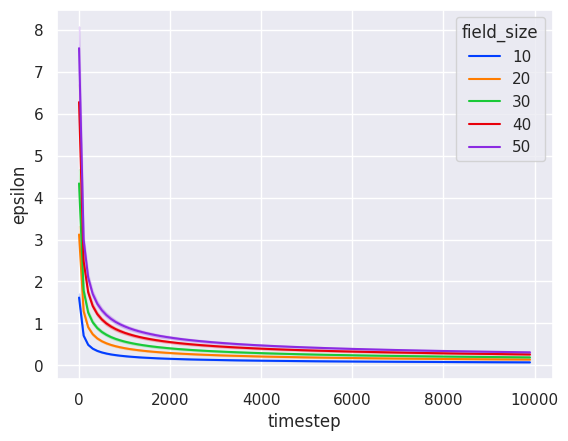

In [34]:
sns.set_theme(style="darkgrid")


# Plot the responses for different events and regions
sns.lineplot(x="timestep", y="epsilon", hue="field_size", data=df, palette="bright")

In [18]:
import time
import numpy as np
runtimes = []
for f_size in range(10,200,10):
    field = np.random.randint(2,6,f_size)
    start = time.time()
    ficticiousPlay(field, ta, td, max_iters=max_iters, epsilon=0.0)
    end = time.time()
    runtimes.append((f_size, end-start))

# question 2.2 

We can observe that the grwoth is linear

/tmp/ipykernel_1190329/2524152520.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x = 'num_fields', y='time', data=df_times, palette="bright")


<Axes: xlabel='num_fields', ylabel='time'>

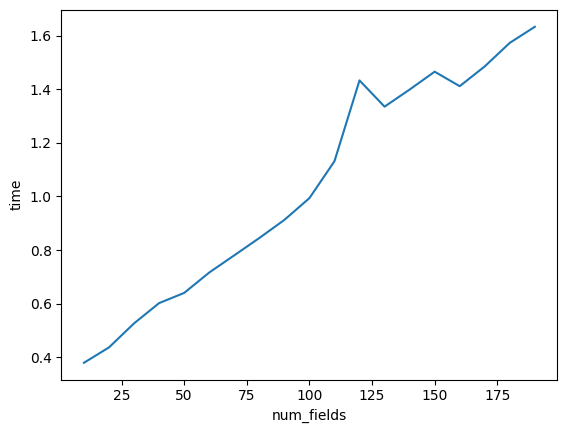

In [19]:
import seaborn as sns

df_times = pd.DataFrame(runtimes, columns=["num_fields", "time"])

sns.lineplot(x = 'num_fields', y='time', data=df_times, palette="bright")

# question 2.3

The analysis of the achieved approximation of value of epsilon with respect to different starting strategies doesn't draw any interesting conclusions. There were 7 starting strategies checked:
1) no starting strategy (normal Fictitious Play)
2) uniform distributions over probabilities of which battlefield players assign a resource to
3) attackers starts with pure strategy picking bA least valueable battlefields, while defender bD most valueable
4) both players start with pure strategy picking bA or bD most valueable battlefields
5) defender starts with pure strategy picking bD least valueable battlefields, while attacker splits half of resources to each least and most valueable ones
6) attacker picks least valueable battlefield with probability 1 and distributes the rest uniformly over the rest of battlefields, defender does the same but picks most valueable battlefield
7) both players pick least valueable battlefield with probability 1 and distribute the rest uniformly over the rest of battlefields

First tests were done with 100000 rounds limit on random battlefields of size between 30 and 40 and there seemed to be no specific rule whatsoever. All approximations (in a scope of one test) with respect to starting strategy were better or worse comparing to no strategy depending on the test. There seemed to be a rule that "no strategy" strategy ended up with the worst approximation when difference of resources given to both players was over n / 2, but again, not for all tests.

The next approach was approximating epsilon for "no strategy" within 100000 rounds and checking how many rounds other starting strategies require to reach it. This time the number of checked battlefields was 10 and 45. The only tendency we could observe is that for mid and high tests, which operate on number of resources from range (n/3, 2n/3) and (2n/3, n) respectively, the number of required rounds was lower - sometimes by just few hundred, but in extreme case it was by 22000.